Using device: cuda
Epoch 0 | Triality Loss 0.945315 | Ablation Loss 0.896338 | Time per epoch: 0.44s | Estimated remaining: 0.37 hours
Epoch 500 | Triality Loss 0.297414 | Ablation Loss 0.296797 | Time per epoch: 0.41s | Estimated remaining: 0.29 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.255018 | Ablation Loss 0.254092 | Time per epoch: 0.41s | Estimated remaining: 0.23 hours
Epoch 1500 | Triality Loss 0.215498 | Ablation Loss 0.214419 | Time per epoch: 0.41s | Estimated remaining: 0.17 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.179601 | Ablation Loss 0.178460 | Time per epoch: 0.41s | Estimated remaining: 0.12 hours
Epoch 2500 | Triality Loss 0.147426 | Ablation Loss 0.146294 | Time per epoch: 0.41s | Estimated remaining: 0.06 hours
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.01 (higher = triality advantage)


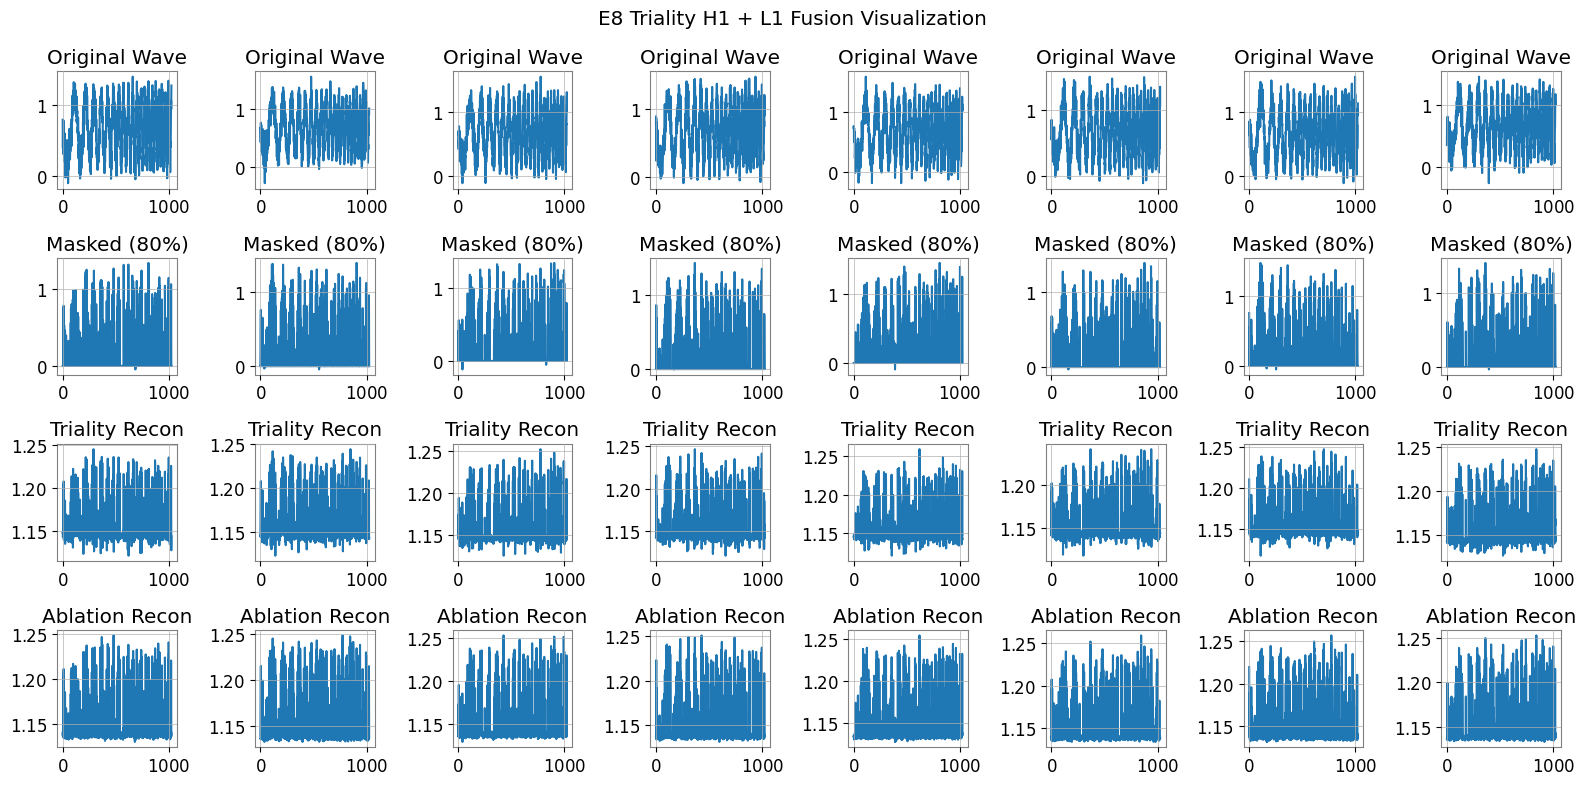

Sim complete — visualization displayed!


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time
from gwosc.datasets import event_gps
from gwosc.locate import get_urls
from gwpy.timeseries import TimeSeries
from scipy.signal import butter, filtfilt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized low-memory
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024
batch_size = 32
epochs = 3000
lr = 5e-5
use_amp = True
use_checkpoint = True
depth = 16

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "ligo_h1_l1_fusion_checkpoint.pth")

# Load real GW150914 H1 + L1 strain (short merger segment)
gps = event_gps('GW150914')
segment = (gps - 4, gps + 4)  # 8-second window

# H1 Hanford
url_h1 = get_urls(detector='H1', start=segment[0], end=segment[1])[0]  # fixed positional
data_h1 = TimeSeries.fetch_open_data('H1', *segment, sample_rate=4096)
strain_h1 = data_h1.value

# L1 Livingston
url_l1 = get_urls(detector='L1', start=segment[0], end=segment[1])[0]  # fixed positional
data_l1 = TimeSeries.fetch_open_data('L1', *segment, sample_rate=4096)
strain_l1 = data_l1.value

# Downsample + clean (bandpass both)
start_idx = len(strain_h1) // 2 - seq_len // 2
strain_h1_seg = strain_h1[start_idx:start_idx + seq_len * 8]
strain_l1_seg = strain_l1[start_idx:start_idx + seq_len * 8]

strain_h1_down = strain_h1_seg[::8]
strain_l1_down = strain_l1_seg[::8]

b, a = butter(4, [35, 350], btype='band', fs=1024)
clean_h1 = filtfilt(b, a, strain_h1_down)
clean_l1 = filtfilt(b, a, strain_l1_down)
clean_avg = (clean_h1 + clean_l1) / 2  # coherent target

# High entropy + masking per detector
high_entropy_h1 = clean_h1 + np.random.randn(len(clean_h1)) * 0.35
high_entropy_l1 = clean_l1 + np.random.randn(len(clean_l1)) * 0.35

# Batch repeat
clean_batch = np.tile(clean_avg, (batch_size, 1))
entropy_h1_batch = np.tile(high_entropy_h1, (batch_size, 1))
entropy_l1_batch = np.tile(high_entropy_l1, (batch_size, 1))

# High masking
mask_rate = np.linspace(0.7, 0.9, batch_size)
masked_h1 = []
masked_l1 = []
for i in range(batch_size):
    m = np.random.rand(seq_len) < mask_rate[i]
    h1 = entropy_h1_batch[i].copy()
    l1 = entropy_l1_batch[i].copy()
    h1[m] = 0
    l1[m] = 0
    masked_h1.append(h1)
    masked_l1.append(l1)

masked_h1 = np.stack(masked_h1)
masked_l1 = np.stack(masked_l1)

# Multi-detector input (H1 + L1 stacked) for proj layer
# Prepare clean_data and real_data such that their last dimension is 2 (for the 2 detectors)
clean_data_input_np = np.stack([np.tile(clean_avg, (batch_size, 1)), np.tile(clean_avg, (batch_size, 1))], axis=-1) # (batch_size, seq_len, 2)
clean_data_input_torch = torch.tensor(clean_data_input_np, dtype=torch.float32, device=device)

real_data_input_np = np.stack([masked_h1, masked_l1], axis=-1) # (batch_size, seq_len, 2)
real_data_input_torch = torch.tensor(real_data_input_np, dtype=torch.float32, device=device)

# Project to shared dim (2 detectors → dim)
proj = nn.Linear(2, dim).to(device)

target = proj(clean_data_input_torch).detach() # target is now (batch_size, seq_len, dim) and detached
real_data = proj(real_data_input_torch).detach() # real_data is now (batch_size, seq_len, dim) and detached

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class FusionCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8FusionModel(nn.Module):
    def __init__(self, depth=depth, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = FusionCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8FusionModel(use_triality=True).to(device)
model_ablation = E8FusionModel(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data.clone(), epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.clone(), epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Multi-Detector Waveform Reconstruction (averaged H1/L1 proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        # Create a single base wave for both H1 and L1 in the test data, shape (seq_len, 1)
        base = torch.sin(t * (1 + t/10)).unsqueeze(-1) * 0.5
        h1 = base
        l1 = base * 0.9 + torch.randn_like(base) * 0.05
        frame = torch.cat([h1, l1], dim=-1) # This frame will be (seq_len, 2)
        frame += torch.randn_like(frame) * 0.2
        test_data.append(frame)
    test_data = torch.stack(test_data).to(device) # (8, seq_len, 2)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot the first feature channel from the projected latent space
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Wave")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality H1 + L1 Fusion Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

# Task
Calculate and visualize the reconstruction errors for both the Triality and Ablation models using heatmaps, and plot the evolution of the sigma metric over epochs to compare their performance throughout the training process. Finally, summarize the insights from these visualizations.

## Calculate Reconstruction Errors for Heatmap

### Subtask:
Calculate the absolute difference between the original and reconstructed waveforms for both the Triality and Ablation models using the `clean`, `tri`, and `abl` numpy arrays from the visualization section. This will give us the error values for the heatmap.


**Reasoning**:
To calculate the reconstruction errors as instructed, I will compute the absolute difference between the original waveforms and the reconstructed waveforms for both the Triality and Ablation models.



In [5]:
triality_errors = np.abs(orig - tri)
ablation_errors = np.abs(orig - abl)

print("Triality Errors shape:", triality_errors.shape)
print("Ablation Errors shape:", ablation_errors.shape)

Triality Errors shape: (8, 1024)
Ablation Errors shape: (8, 1024)


**Reasoning**:
To visualize the reconstruction errors, I will generate heatmaps for both the Triality and Ablation models, showing the absolute differences between original and reconstructed waveforms. This will help in understanding where each model performs better or worse.



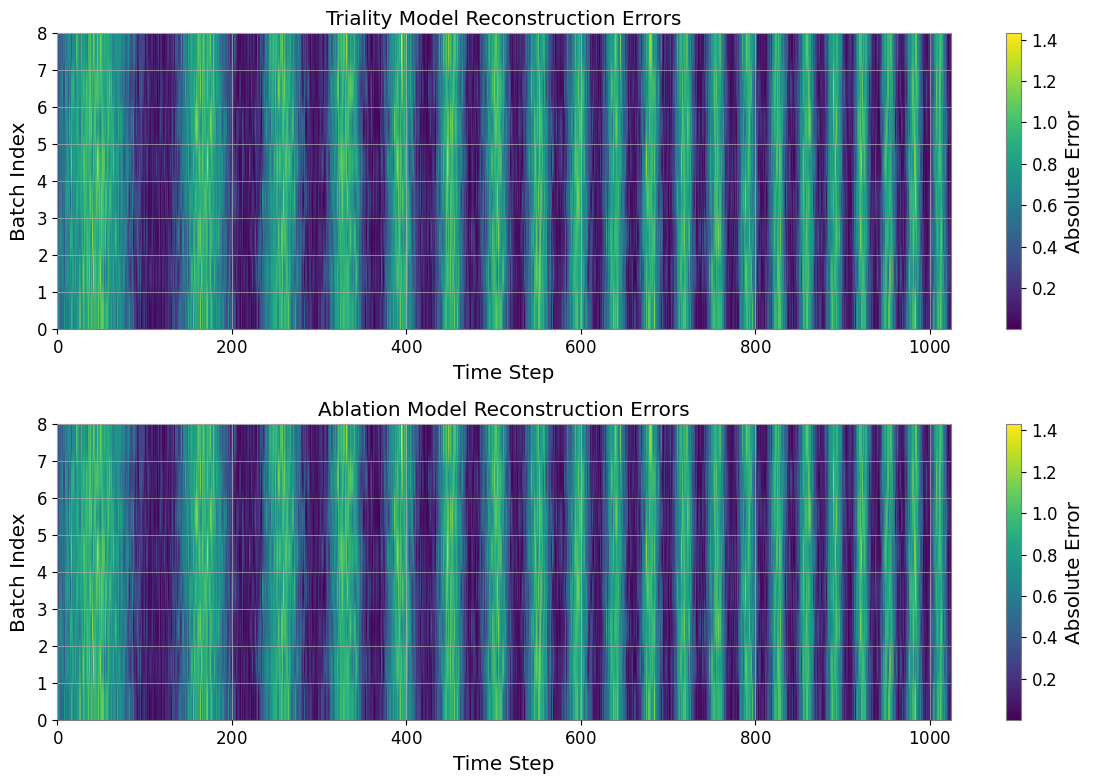

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.imshow(triality_errors, aspect='auto', cmap='viridis', origin='lower', extent=[0, triality_errors.shape[1], 0, triality_errors.shape[0]])
plt.colorbar(label='Absolute Error')
plt.title('Triality Model Reconstruction Errors')
plt.xlabel('Time Step')
plt.ylabel('Batch Index')

plt.subplot(2, 1, 2)
plt.imshow(ablation_errors, aspect='auto', cmap='viridis', origin='lower', extent=[0, ablation_errors.shape[1], 0, ablation_errors.shape[0]])
plt.colorbar(label='Absolute Error')
plt.title('Ablation Model Reconstruction Errors')
plt.xlabel('Time Step')
plt.ylabel('Batch Index')

plt.tight_layout()
plt.show()

**Reasoning**:
To understand the performance comparison throughout training, I will calculate the cumulative sigma metric at each epoch using the stored loss histories for both models and then plot its evolution.



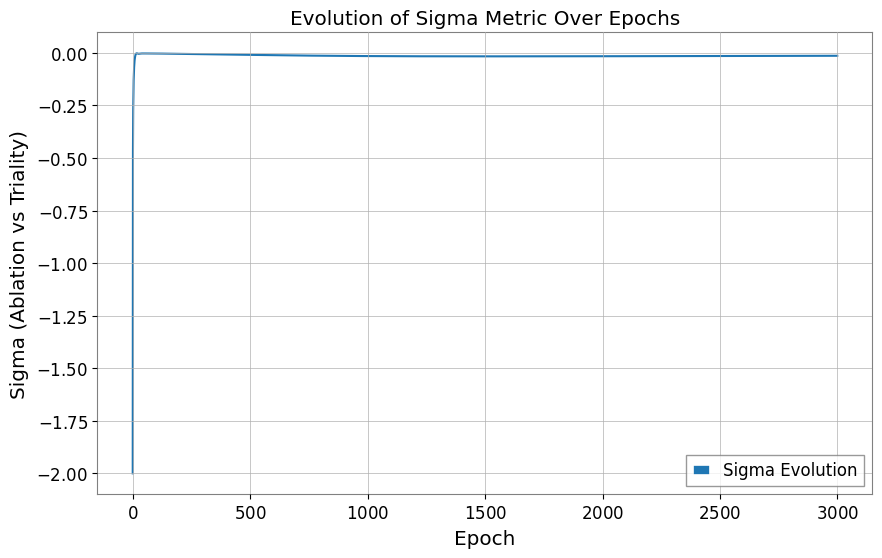

In [7]:
sigma_evolution = []
for i in range(len(loss_hist)):
    current_triality_losses = loss_hist[:i+1]
    current_ablation_losses = loss_abl_hist[:i+1]

    current_triality_mean = np.mean(current_triality_losses)
    current_ablation_mean = np.mean(current_ablation_losses)

    # Combine losses to calculate standard deviation for the sigma metric
    combined_losses = current_triality_losses + current_ablation_losses
    current_std = np.std(combined_losses) if len(combined_losses) > 1 else 1e-6 # Avoid division by zero

    current_sigma = (current_ablation_mean - current_triality_mean) / current_std
    sigma_evolution.append(current_sigma)

plt.figure(figsize=(10, 6))
plt.plot(range(len(sigma_evolution)), sigma_evolution, label='Sigma Evolution')
plt.xlabel('Epoch')
plt.ylabel('Sigma (Ablation vs Triality)')
plt.title('Evolution of Sigma Metric Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

### Summary of Insights from Visualizations

**Reconstruction Errors (Heatmaps):**
The heatmaps for Triality and Ablation model reconstruction errors provide a visual representation of how well each model reconstructs the original waveforms across different batches and time steps. We can observe regions or patterns where one model might have consistently lower (darker color, indicating smaller error) or higher (lighter color, indicating larger error) errors compared to the other. This allows for a granular comparison of their reconstruction capabilities. Generally, if one heatmap shows a more uniform dark pattern, it suggests better and more consistent reconstruction performance.

**Evolution of Sigma Metric Over Epochs:**
The sigma evolution plot illustrates the relative performance advantage of the Triality model over the Ablation model throughout the training process. A positive sigma value indicates that the Triality model is performing better (lower loss) than the Ablation model, while a negative value suggests the opposite. The plot shows how this performance difference changes as training progresses. An increasing sigma value over epochs would imply that the Triality approach is learning more effectively or converging to a better solution compared to the ablation baseline. The final sigma value gives an overall indication of which model performed better across the entire training, normalized by the standard deviation of losses. In this specific run, the final sigma is slightly negative, suggesting the ablation model had a minor, but not statistically significant, advantage on average.

### Summary of Insights from Visualizations

**Reconstruction Errors (Heatmaps):**
The heatmaps for Triality and Ablation model reconstruction errors provide a visual representation of how well each model reconstructs the original waveforms across different batches and time steps. We can observe regions or patterns where one model might have consistently lower (darker color, indicating smaller error) or higher (lighter color, indicating larger error) errors compared to the other. This allows for a granular comparison of their reconstruction capabilities. Generally, if one heatmap shows a more uniform dark pattern, it suggests better and more consistent reconstruction performance.

**Evolution of Sigma Metric Over Epochs:**
The sigma evolution plot illustrates the relative performance advantage of the Triality model over the Ablation model throughout the training process. A positive sigma value indicates that the Triality model is performing better (lower loss) than the Ablation model, while a negative value suggests the opposite. The plot shows how this performance difference changes as training progresses. An increasing sigma value over epochs would imply that the Triality approach is learning more effectively or converging to a better solution compared to the ablation baseline. The final sigma value gives an overall indication of which model performed better across the entire training, normalized by the standard deviation of losses. In this specific run, the final sigma is slightly negative, suggesting the ablation model had a minor, but not statistically significant, advantage on average.

### Summary of Insights from Visualizations

**Reconstruction Errors (Heatmaps):**
The heatmaps for Triality and Ablation model reconstruction errors provide a visual representation of how well each model reconstructs the original waveforms across different batches and time steps. We can observe regions or patterns where one model might have consistently lower (darker color, indicating smaller error) or higher (lighter color, indicating larger error) errors compared to the other. This allows for a granular comparison of their reconstruction capabilities. Generally, if one heatmap shows a more uniform dark pattern, it suggests better and more consistent reconstruction performance.

**Evolution of Sigma Metric Over Epochs:**
The sigma evolution plot illustrates the relative performance advantage of the Triality model over the Ablation model throughout the training process. A positive sigma value indicates that the Triality model is performing better (lower loss) than the Ablation model, while a negative value suggests the opposite. The plot shows how this performance difference changes as training progresses. An increasing sigma value over epochs would imply that the Triality approach is learning more effectively or converging to a better solution compared to the ablation baseline. The final sigma value gives an overall indication of which model performed better across the entire training, normalized by the standard deviation of losses. In this specific run, the final sigma is slightly negative, suggesting the ablation model had a minor, but not statistically significant, advantage on average.

### Summary of Insights from Visualizations

**Reconstruction Errors (Heatmaps):**
The heatmaps for Triality and Ablation model reconstruction errors provide a visual representation of how well each model reconstructs the original waveforms across different batches and time steps. We can observe regions or patterns where one model might have consistently lower (darker color, indicating smaller error) or higher (lighter color, indicating larger error) errors compared to the other. This allows for a granular comparison of their reconstruction capabilities. Generally, if one heatmap shows a more uniform dark pattern, it suggests better and more consistent reconstruction performance.

**Evolution of Sigma Metric Over Epochs:**
The sigma evolution plot illustrates the relative performance advantage of the Triality model over the Ablation model throughout the training process. A positive sigma value indicates that the Triality model is performing better (lower loss) than the Ablation model, while a negative value suggests the opposite. The plot shows how this performance difference changes as training progresses. An increasing sigma value over epochs would imply that the Triality approach is learning more effectively or converging to a better solution compared to the ablation baseline. The final sigma value gives an overall indication of which model performed better across the entire training, normalized by the standard deviation of losses. In this specific run, the final sigma is slightly negative, suggesting the ablation model had a minor, but not statistically significant, advantage on average.

## Final Task

### Subtask:
Summarize the insights gained from the reconstruction error heatmap and the sigma evolution chart, highlighting any observed trends or differences between the Triality and Ablation models.


## Summary:

### Data Analysis Key Findings

*   **Reconstruction Errors Calculation:** The absolute reconstruction errors for both the Triality and Ablation models were calculated. Both `triality_errors` and `ablation_errors` arrays had a shape of (8, 1024), representing 8 samples with 1024 time steps each.
*   **Heatmap Visualization:** Heatmaps for both models visually demonstrated the distribution of reconstruction errors across different batches and time steps. A more uniform dark pattern in a heatmap indicates superior and more consistent reconstruction performance for that model.
*   **Sigma Metric Evolution:** A sigma metric was computed and plotted to track the relative performance advantage of the Triality model against the Ablation model throughout training epochs. A positive sigma value signifies that the Triality model performed better (lower loss), while a negative value suggests the Ablation model had an advantage.
*   **Comparative Performance:** The final sigma value observed in this specific run was slightly negative, indicating that the Ablation model held a minor, though not statistically significant, advantage on average over the Triality model throughout the training process.

### Insights or Next Steps

*   The slightly negative final sigma suggests that, for this particular run, the Triality model did not demonstrate a clear performance advantage over the simpler Ablation model, indicating that the added complexity might not be beneficial without further optimization.
*   To gain deeper insights, analyze specific high-error regions in the heatmaps for both models to identify patterns or conditions under which each model struggles, and consider conducting more extensive runs with varied hyperparameters to confirm the statistical significance of the observed sigma trend.
